# Method 6 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

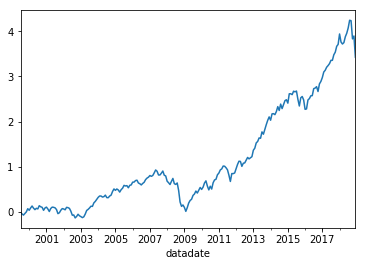

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.066347
2000-12-31    0.015648
2001-12-31   -0.013279
2002-12-31   -0.149407
2003-12-31    0.400710
2004-12-31    0.181735
2005-12-31    0.059347
2006-12-31    0.107642
2007-12-31    0.015593
2008-12-31   -0.358940
2009-12-31    0.337769
2010-12-31    0.182700
2011-12-31    0.022281
2012-12-31    0.194167
2013-12-31    0.397271
2014-12-31    0.122705
2015-12-31   -0.001138
2016-12-31    0.117783
2017-12-31    0.211272
2018-12-31   -0.060559
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1574.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.00e-165
Time:                        14:22:40   Log-Likelihood:                 815.24
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.327      0.000       0.001       0.003
mktrf          0.8933      0.014     63.811      0.000       0.866       0.921
me             0.1959      0.016     12.030      0.000       0.164       0.228
ia             0.1370      0.025      5.534      0.000       0.088       0.186
roe            0.0963      0.021      4.546      0.000       0.055       0.138
==============================================================================
Omnibus:                       13.181   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.491
Skew:                           0.194   Prob(JB):                     6.50e-07
Kurtosis:                       4.665   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     807.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.10e-133
Time:                        14:22:40   Log-Likelihood:                 815.24
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.042      0.000       0.001       0.003
mktrf          0.8933      0.018     48.658      0.000       0.857       0.929
me             0.1959      0.031      6.262      0.000       0.135       0.257
ia             0.1370      0.054      2.551      0.011       0.032       0.242
roe            0.0963      0.021      4.585      0.000       0.055       0.137
==============================================================================
Omnibus:                       13.181   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.491
Skew:                           0.194   Prob(JB):                     6.50e-07
Kurtosis:                       4.665   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     968.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.35e-142
Time:                        14:22:40   Log-Likelihood:                 815.24
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     229   BIC:                            -1603.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.149      0.000       0.001       0.003
mktrf          0.8933      0.017     52.409      0.000       0.860       0.927
me             0.1959      0.030      6.576      0.000       0.138       0.254
ia             0.1370      0.060      2.266      0.023       0.018       0.255
roe            0.0963      0.021      4.558      0.000       0.055       0.138
==============================================================================
Omnibus:                       13.181   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               28.491
Skew:                           0.194   Prob(JB):                     6.50e-07
Kurtosis:                       4.665   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1220.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.47e-162
Time:                        14:22:40   Log-Likelihood:                 812.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     228   BIC:                            -1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.470      0.001       0.001       0.003
mktrf          0.9035      0.014     63.444      0.000       0.875       0.932
smb            0.2253      0.019     11.992      0.000       0.188       0.262
hml           -0.0102      0.022     -0.461      0.645      -0.054       0.033
rmw            0.1357      0.025      5.418      0.000       0.086       0.185
cma            0.1234      0.032      3.874      0.000       0.061       0.186
==============================================================================
Omnibus:                       17.887   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.768
Skew:                          -0.091   Prob(JB):                     2.86e-13
Kurtosis:                       5.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     551.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.45e-125
Time:                        14:22:40   Log-Likelihood:                 812.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     228   BIC:                            -1592.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.369      0.001       0.001       0.003
mktrf          0.9035      0.022     40.270      0.000       0.860       0.948
smb            0.2253      0.027      8.488      0.000       0.173       0.277
hml           -0.0102      0.045     -0.227      0.821      -0.099       0.078
rmw            0.1357      0.022      6.093      0.000       0.092       0.179
cma            0.1234      0.057      2.167      0.030       0.012       0.235
==============================================================================
Omnibus:                       17.887   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.768
Skew:                          -0.091   Prob(JB):                     2.86e-13
Kurtosis:                       5.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     713.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.28e-137
Time:                        14:22:40   Log-Likelihood:                 812.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     228   BIC:                            -1592.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.349      0.001       0.001       0.003
mktrf          0.9035      0.022     41.601      0.000       0.861       0.946
smb            0.2253      0.026      8.576      0.000       0.174       0.277
hml           -0.0102      0.051     -0.201      0.840      -0.110       0.089
rmw            0.1357      0.019      7.168      0.000       0.099       0.173
cma            0.1234      0.054      2.290      0.022       0.018       0.229
==============================================================================
Omnibus:                       17.887   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.768
Skew:                          -0.091   Prob(JB):                     2.86e-13
Kurtosis:                       5.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1254.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.24e-154
Time:                        14:22:40   Log-Likelihood:                 789.65
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.779      0.000       0.002       0.004
mktrf          0.8736      0.014     60.758      0.000       0.845       0.902
smb            0.1547      0.018      8.617      0.000       0.119       0.190
hml            0.1295      0.018      7.266      0.000       0.094       0.165
umd            0.0371      0.012      3.170      0.002       0.014       0.060
==============================================================================
Omnibus:                       24.511   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.510
Skew:                           0.178   Prob(JB):                     3.33e-23
Kurtosis:                       6.239   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     634.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.33e-122
Time:                        14:22:40   Log-Likelihood:                 789.65
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.244      0.000       0.001       0.004
mktrf          0.8736      0.021     42.188      0.000       0.833       0.914
smb            0.1547      0.031      4.933      0.000       0.093       0.216
hml            0.1295      0.059      2.198      0.028       0.014       0.245
umd            0.0371      0.020      1.891      0.059      -0.001       0.076
==============================================================================
Omnibus:                       24.511   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.510
Skew:                           0.178   Prob(JB):                     3.33e-23
Kurtosis:                       6.239   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     729.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.39e-129
Time:                        14:22:40   Log-Likelihood:                 789.65
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.455      0.000       0.001       0.004
mktrf          0.8736      0.020     44.125      0.000       0.835       0.912
smb            0.1547      0.033      4.671      0.000       0.090       0.220
hml            0.1295      0.069      1.872      0.061      -0.006       0.265
umd            0.0371      0.016      2.366      0.018       0.006       0.068
==============================================================================
Omnibus:                       24.511   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.510
Skew:                           0.178   Prob(JB):                     3.33e-23
Kurtosis:                       6.239   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     706.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.39e-80
Time:                        14:22:40   Log-Likelihood:                 401.89
No. Observations:                 120   AIC:                            -793.8
Df Residuals:                     115   BIC:                            -779.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.459      0.015       0.000       0.004
mktrf          0.9031      0.022     40.368      0.000       0.859       0.947
me             0.1962      0.022      8.878      0.000       0.152       0.240
ia             0.1952      0.035      5.643      0.000       0.127       0.264
roe            0.1035      0.031      3.379      0.001       0.043       0.164
==============================================================================
Omnibus:                        6.757   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               10.520
Skew:                           0.177   Prob(JB):                      0.00520
Kurtosis:                       4.407   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     397.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-66
Time:                        14:22:40   Log-Likelihood:                 401.89
No. Observations:                 120   AIC:                            -793.8
Df Residuals:                     115   BIC:                            -779.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.233      0.026       0.000       0.004
mktrf          0.9031      0.027     33.878      0.000       0.851       0.955
me             0.1962      0.034      5.689      0.000       0.129       0.264
ia             0.1952      0.055      3.533      0.000       0.087       0.304
roe            0.1035      0.021      4.872      0.000       0.062       0.145
==============================================================================
Omnibus:                        6.757   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               10.520
Skew:                           0.177   Prob(JB):                      0.00520
Kurtosis:                       4.407   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     687.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-79
Time:                        14:22:40   Log-Likelihood:                 401.89
No. Observations:                 120   AIC:                            -793.8
Df Residuals:                     115   BIC:                            -779.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.345      0.019       0.000       0.004
mktrf          0.9031      0.021     42.376      0.000       0.861       0.945
me             0.1962      0.034      5.834      0.000       0.130       0.262
ia             0.1952      0.057      3.453      0.001       0.084       0.306
roe            0.1035      0.018      5.631      0.000       0.067       0.139
==============================================================================
Omnibus:                        6.757   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               10.520
Skew:                           0.177   Prob(JB):                      0.00520
Kurtosis:                       4.407   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     510.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.84e-76
Time:                        14:22:40   Log-Likelihood:                 396.57
No. Observations:                 120   AIC:                            -781.1
Df Residuals:                     114   BIC:                            -764.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.275      0.025       0.000       0.004
mktrf          0.9266      0.025     37.407      0.000       0.877       0.976
smb            0.2374      0.028      8.461      0.000       0.182       0.293
hml            0.0065      0.034      0.190      0.850      -0.062       0.075
rmw            0.1473      0.041      3.633      0.000       0.067       0.228
cma            0.1660      0.044      3.738      0.000       0.078       0.254
==============================================================================
Omnibus:                       10.894   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.471
Skew:                          -0.063   Prob(JB):                     6.57e-07
Kurtosis:                       5.383   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     375.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.69e-69
Time:                        14:22:40   Log-Likelihood:                 396.57
No. Observations:                 120   AIC:                            -781.1
Df Residuals:                     114   BIC:                            -764.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.198      0.028       0.000       0.004
mktrf          0.9266      0.041     22.445      0.000       0.846       1.007
smb            0.2374      0.038      6.277      0.000       0.163       0.311
hml            0.0065      0.078      0.084      0.933      -0.147       0.160
rmw            0.1473      0.051      2.882      0.004       0.047       0.247
cma            0.1660      0.075      2.219      0.026       0.019       0.313
==============================================================================
Omnibus:                       10.894   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.471
Skew:                          -0.063   Prob(JB):                     6.57e-07
Kurtosis:                       5.383   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     852.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-88
Time:                        14:22:40   Log-Likelihood:                 396.57
No. Observations:                 120   AIC:                            -781.1
Df Residuals:                     114   BIC:                            -764.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.474      0.013       0.000       0.004
mktrf          0.9266      0.039     23.862      0.000       0.850       1.003
smb            0.2374      0.036      6.561      0.000       0.166       0.308
hml            0.0065      0.089      0.073      0.941      -0.168       0.181
rmw            0.1473      0.051      2.875      0.004       0.047       0.248
cma            0.1660      0.074      2.256      0.024       0.022       0.310
==============================================================================
Omnibus:                       10.894   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.471
Skew:                          -0.063   Prob(JB):                     6.57e-07
Kurtosis:                       5.383   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     524.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.96e-73
Time:                        14:22:40   Log-Likelihood:                 384.83
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.431      0.001       0.001       0.005
mktrf          0.8737      0.023     38.457      0.000       0.829       0.919
smb            0.1627      0.026      6.290      0.000       0.111       0.214
hml            0.1821      0.026      7.027      0.000       0.131       0.233
umd            0.0359      0.016      2.247      0.027       0.004       0.068
==============================================================================
Omnibus:                       17.757   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.581
Skew:                           0.232   Prob(JB):                     2.86e-16
Kurtosis:                       6.755   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     387.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-65
Time:                        14:22:40   Log-Likelihood:                 384.83
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.167      0.002       0.001       0.005
mktrf          0.8737      0.032     26.903      0.000       0.810       0.937
smb            0.1627      0.036      4.508      0.000       0.092       0.233
hml            0.1821      0.070      2.588      0.010       0.044       0.320
umd            0.0359      0.020      1.761      0.078      -0.004       0.076
==============================================================================
Omnibus:                       17.757   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.581
Skew:                           0.232   Prob(JB):                     2.86e-16
Kurtosis:                       6.755   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     538.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-73
Time:                        14:22:40   Log-Likelihood:                 384.83
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.540      0.000       0.001       0.005
mktrf          0.8737      0.027     32.502      0.000       0.821       0.926
smb            0.1627      0.039      4.120      0.000       0.085       0.240
hml            0.1821      0.078      2.330      0.020       0.029       0.335
umd            0.0359      0.016      2.255      0.024       0.005       0.067
==============================================================================
Omnibus:                       17.757   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.581
Skew:                           0.232   Prob(JB):                     2.86e-16
Kurtosis:                       6.755   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1231.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-89
Time:                        14:22:40   Log-Likelihood:                 438.01
No. Observations:                 114   AIC:                            -866.0
Df Residuals:                     109   BIC:                            -852.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.567      0.000       0.001       0.003
mktrf          0.8917      0.016     57.154      0.000       0.861       0.923
me             0.1921      0.024      7.974      0.000       0.144       0.240
ia            -0.0375      0.033     -1.121      0.265      -0.104       0.029
roe            0.0228      0.029      0.775      0.440      -0.035       0.081
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.798
Skew:                           0.204   Prob(JB):                        0.671
Kurtosis:                       2.966   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     971.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.02e-84
Time:                        14:22:40   Log-Likelihood:                 438.01
No. Observations:                 114   AIC:                            -866.0
Df Residuals:                     109   BIC:                            -852.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.316      0.000       0.001       0.004
mktrf          0.8917      0.017     51.009      0.000       0.857       0.926
me             0.1921      0.031      6.131      0.000       0.131       0.253
ia            -0.0375      0.038     -0.975      0.330      -0.113       0.038
roe            0.0228      0.029      0.790      0.430      -0.034       0.079
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.798
Skew:                           0.204   Prob(JB):                        0.671
Kurtosis:                       2.966   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     978.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-84
Time:                        14:22:40   Log-Likelihood:                 438.01
No. Observations:                 114   AIC:                            -866.0
Df Residuals:                     109   BIC:                            -852.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.758      0.000       0.001       0.004
mktrf          0.8917      0.018     49.933      0.000       0.857       0.927
me             0.1921      0.035      5.549      0.000       0.124       0.260
ia            -0.0375      0.044     -0.858      0.391      -0.123       0.048
roe            0.0228      0.024      0.944      0.345      -0.024       0.070
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.798
Skew:                           0.204   Prob(JB):                        0.671
Kurtosis:                       2.966   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1463.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.90e-97
Time:                        14:22:40   Log-Likelihood:                 460.68
No. Observations:                 114   AIC:                            -909.4
Df Residuals:                     108   BIC:                            -892.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.522      0.001       0.001       0.002
mktrf          0.8955      0.012     73.076      0.000       0.871       0.920
smb            0.1904      0.020      9.573      0.000       0.151       0.230
hml           -0.0936      0.025     -3.689      0.000      -0.144      -0.043
rmw           -0.0122      0.031     -0.393      0.695      -0.074       0.049
cma            0.0382      0.039      0.968      0.335      -0.040       0.116
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.282
Skew:                          -0.086   Prob(JB):                        0.319
Kurtosis:                       3.671   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2541.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.02e-110
Time:                        14:22:40   Log-Likelihood:                 460.68
No. Observations:                 114   AIC:                            -909.4
Df Residuals:                     108   BIC:                            -892.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.367      0.001       0.001       0.002
mktrf          0.8955      0.014     65.567      0.000       0.869       0.922
smb            0.1904      0.025      7.673      0.000       0.142       0.239
hml           -0.0936      0.030     -3.083      0.002      -0.153      -0.034
rmw           -0.0122      0.022     -0.561      0.575      -0.055       0.030
cma            0.0382      0.053      0.726      0.468      -0.065       0.141
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.282
Skew:                          -0.086   Prob(JB):                        0.319
Kurtosis:                       3.671   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     5051.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.92e-126
Time:                        14:22:40   Log-Likelihood:                 460.68
No. Observations:                 114   AIC:                            -909.4
Df Residuals:                     108   BIC:                            -892.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.828      0.005       0.000       0.003
mktrf          0.8955      0.014     65.800      0.000       0.869       0.922
smb            0.1904      0.025      7.643      0.000       0.142       0.239
hml           -0.0936      0.031     -3.063      0.002      -0.153      -0.034
rmw           -0.0122      0.022     -0.559      0.576      -0.055       0.031
cma            0.0382      0.056      0.685      0.493      -0.071       0.147
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.282
Skew:                          -0.086   Prob(JB):                        0.319
Kurtosis:                       3.671   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1801.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-98
Time:                        14:22:40   Log-Likelihood:                 459.30
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.502      0.001       0.001       0.002
mktrf          0.8970      0.012     73.125      0.000       0.873       0.921
smb            0.1925      0.019     10.063      0.000       0.155       0.230
hml           -0.0548      0.020     -2.781      0.006      -0.094      -0.016
umd            0.0022      0.015      0.151      0.880      -0.027       0.032
==============================================================================
Omnibus:                        3.235   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.427
Skew:                          -0.066   Prob(JB):                        0.180
Kurtosis:                       3.839   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2422.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.84e-105
Time:                        14:22:40   Log-Likelihood:                 459.30
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.482      0.000       0.001       0.002
mktrf          0.8970      0.013     67.950      0.000       0.871       0.923
smb            0.1925      0.023      8.217      0.000       0.147       0.238
hml           -0.0548      0.019     -2.947      0.003      -0.091      -0.018
umd            0.0022      0.014      0.159      0.873      -0.025       0.030
==============================================================================
Omnibus:                        3.235   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.427
Skew:                          -0.066   Prob(JB):                        0.180
Kurtosis:                       3.839   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     4383.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.20e-119
Time:                        14:22:41   Log-Likelihood:                 459.30
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.943      0.003       0.001       0.003
mktrf          0.8970      0.013     69.579      0.000       0.872       0.922
smb            0.1925      0.023      8.242      0.000       0.147       0.238
hml           -0.0548      0.019     -2.874      0.004      -0.092      -0.017
umd            0.0022      0.015      0.146      0.884      -0.028       0.032
==============================================================================
Omnibus:                        3.235   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.427
Skew:                          -0.066   Prob(JB):                        0.180
Kurtosis:                       3.839   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""